In [1]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from yellowbrick.cluster import KElbow
from mlxtend.frequent_patterns import fpgrowth
import warnings
warnings.filterwarnings(action="ignore")
%load_ext autotime
# %matplotlib inline
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [2]:
class Binner():
    
    def __init__(self, df):
        self.df = df
        self.models = {}
        
    def sort_model_labels(model, number_of_bins):
        label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
        lookup_table = np.zeros_like(label_idx)
        lookup_table[label_idx] = np.arange(number_of_bins)
        model.labels_ = lookup_table[model.labels_]
        return model
        
    def create_bins(self, column_name, df=None, number_of_bins_range=(2,10), replace_in_df=True):
        """An adaptive binning algorithm to convert a continuous pandas dataframe column to discrete. K means algorithm is used to create bins. Mean sum of squared distances to center is used for evaluation. Knee point detection algorithm is used to select the best number of bins.
        Parameters
        ----------
        column_name : the name of pandas dataframe column to convert
        df : pandas dataframe object, optional (default: self.df)
        number_of_bins_range : tuple, optional
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range (default: (2,10)).
        replace_in_df : boolean, optional
            Whether to replace the column in the dataframe with the binned values (default: True).
        Returns
        -------
        the binned values 
        """
        if df is None:
            df = self.df
        data_to_bin = np.array(df[column_name]).reshape(-1, 1)
        model = KMeans(random_state=100, n_init=10, n_jobs=-1)
        elbow = KElbow(model, k=number_of_bins_range)
        elbow.fit(data_to_bin)
        optimal_number_of_bins = elbow.elbow_value_
        model.set_params(n_clusters=optimal_number_of_bins)
        model.fit(data_to_bin)
        label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
        lookup_table = np.zeros_like(label_idx)
        lookup_table[label_idx] = np.arange(optimal_number_of_bins)
        model.labels_ = lookup_table[model.labels_]
#         self.sort_model_labels(model, optimal_number_of_bins)
        self.models[column_name] = model
        if replace_in_df:
            df[column_name] = model.labels_
        return model.labels_
    
    
    def find_patterns(self, df=None, minimal_support_rate=.33, number_of_bins_range=(2,10)):
        """FP-growth algorithm to find patterns in the dataframe with a minimal support rate, after converting continuous features to discrete
        Parameters
        ----------
        df : pandas dataframe object, optional (default: self.df)
        minimal_support_rate : a float between 0 and 1 for minimum support of the itemsets returned
        number_of_bins_range : tuple, optional
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range (default: (2,10)).
        Returns
        -------
        all patterns found above minimal support rate
        """
        if df is None:
            df = self.df
        for column in df.columns:
            if np.issubdtype(df[column].dtype, np.number):
                try:
                    binned_values = self.create_bins(column, df=df, number_of_bins_range=number_of_bins_range)
                except:
                    pass
        df = pd.get_dummies(df, columns=df.columns)
        self.patterns = fpgrowth(df, min_support=minimal_support_rate, use_colnames=True)
        return self.patterns
    
    def transform_dataset(self, df):
        for column in df.columns:
            if column in self.models:
                model = self.models[column]
                label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
                lookup_table = np.zeros_like(label_idx)
                lookup_table[label_idx] = np.arange(4)
                df[column] = lookup_table[model.predict(np.array(df[column]).reshape(-1,1))]
        df = pd.get_dummies(df, columns=df.columns)
        return df
    
    def get_pattern_support_rate(self, pattern, df):
        pattern_columns = []
        for item in pattern['itemsets']:
            pattern_columns.append(item)
        total_len = len(df)
        support_num = len(pd.np.where(df[pattern_columns].eq(1).all(1))[0])
        support_rate = support_num/total_len
#         print("Pattern Items: {}".format(pattern['itemsets']))
#         print("Original Pattern Support Rate: {}".format(pattern['support']))
#         print("Dataset Pattern Support Rate: {}".format(support_rate))
        return support_rate

    def get_best_subset_patterns(self, full_df, subset_patterns, threshold=1):
        subset_key_patterns = []
        for idx,pattern in subset_patterns.iterrows():
            full_dataset_support_rate = self.get_pattern_support_rate(pattern, self.transform_dataset(full_df.copy()))
            subset_support_rate = pattern['support']
            if full_dataset_support_rate * threshold < subset_support_rate:
#                 print(pattern['itemsets'])
                pattern_list = [item for item in pattern['itemsets']]
                subset_key_patterns.append(pattern_list)
                
        return subset_key_patterns

time: 8.85 ms


In [3]:
import seaborn as sns
iris = sns.load_dataset('iris')
binner = Binner(iris)

time: 629 ms


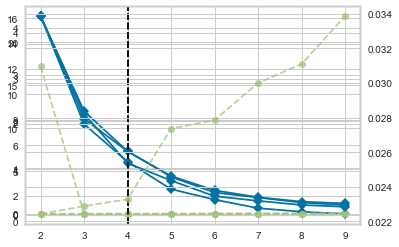

time: 4.89 s


In [4]:
subset_patterns = binner.find_patterns(df=iris[iris['species'] != 'setosa'], minimal_support_rate=.25)

In [5]:
subset_key_patterns = binner.get_best_subset_patterns(iris, subset_patterns, threshold=1.45)
subset_key_patterns

[['species_versicolor'],
 ['petal_length_1'],
 ['petal_width_1'],
 ['sepal_length_1'],
 ['sepal_width_1'],
 ['petal_width_2'],
 ['species_virginica'],
 ['petal_length_2'],
 ['petal_length_1', 'species_versicolor'],
 ['species_versicolor', 'petal_width_1'],
 ['sepal_length_0', 'species_versicolor'],
 ['species_versicolor', 'petal_length_0'],
 ['species_virginica', 'petal_length_2']]

time: 262 ms


In [58]:
threshold = 1.45
subset_key_patterns = []
for idx,pattern in patterns.iterrows():
    full_dataset_support_rate = bins.get_pattern_support_rate(pattern, bins.transform_dataset(iris.copy()))
    subset_support_rate = pattern['support']
    if full_dataset_support_rate * threshold < subset_support_rate:
        print(pattern['itemsets'])
        subset_key_patterns.append(pattern['itemsets'])

frozenset({'species_versicolor'})
frozenset({'petal_length_1'})
frozenset({'petal_width_1'})
frozenset({'sepal_length_1'})
frozenset({'sepal_width_1'})
frozenset({'petal_width_2'})
frozenset({'species_virginica'})
frozenset({'petal_length_2'})
frozenset({'species_versicolor', 'petal_length_1'})
frozenset({'species_versicolor', 'petal_width_1'})
frozenset({'sepal_length_0', 'species_versicolor'})
frozenset({'species_versicolor', 'petal_length_0'})
frozenset({'petal_length_2', 'species_virginica'})
time: 270 ms


In [9]:
.1666 * .5 < .25

True

time: 4.14 ms


In [2]:
def create_bins(df, column_name, number_of_bins_range=(2,10), replace_in_df=True):
    """An adaptive binning algorithm to convert a continuous pandas dataframe column to discrete. K means algorithm is used to create bins. Mean sum of squared distances to center is used for evaluation. Knee point detection algorithm is used to select the best number of bins.
    Parameters
    ----------
    df : pandas dataframe object
    column_name : the name of pandas dataframe column to convert
    number_of_bins_range : tuple, optional
        The range of values for number of bins to try, the algorithm will automatically 
        select the best one from the range (default: (2,10)).
    replace_in_df : boolean, optional
        Whether to replace the column in the dataframe with the binned values (default: True).
    Returns
    -------
    the binned values 
    """
    data_to_bin = np.array(df[column_name]).reshape(-1, 1)
    model = KMeans(random_state=100, n_init=10, n_jobs=-1)
    visualizer = KElbowVisualizer(model, k=number_of_bins_range).fit(data_to_bin)
    optimal_number_of_bins = visualizer.elbow_value_
    model.set_params(n_clusters=optimal_number_of_bins)
    model.fit(data_to_bin)
    label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
    lookup_table = np.zeros_like(label_idx)
    lookup_table[label_idx] = np.arange(optimal_number_of_bins)
    bins = lookup_table[model.labels_]
    if replace_in_df:
        df[column_name] = binned_values
    return binned_values

time: 8.81 ms


In [3]:
def find_patterns(df, minimal_support_rate=.33, number_of_bins_range=(2,10)):
    """FP-growth algorithm to find patterns in the dataframe with a minimal support rate, after converting continuous features to discrete
    Parameters
    ----------
    df : pandas dataframe object
    minimal_support_rate : a float between 0 and 1 for minimum support of the itemsets returned
    number_of_bins_range : tuple, optional
        The range of values for number of bins to try, the algorithm will automatically 
        select the best one from the range (default: (2,10)).
    Returns
    -------
    all patterns found above minimal support rate
    """
    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            try:
                binned_values = create_bins(df, column, number_of_bins_range=number_of_bins_range)
            except e:
                pass
    df = pd.get_dummies(df, columns=df.columns)
    patterns = fpgrowth(df, min_support=minimal_support_rate, use_colnames=True)
    return patterns

time: 2.41 ms


,support,itemsets
0,0.333333,(species_setosa)
1,0.333333,(petal_width_0)
2,0.333333,(petal_length_0)
3,0.406667,(sepal_width_1)
4,0.346667,(petal_width_1)
5,0.333333,(species_versicolor)
6,0.333333,(species_virginica)
7,0.333333,"(petal_width_0, species_setosa)"
8,0.333333,"(petal_length_0, petal_width_0)"
9,0.333333,"(petal_length_0, species_setosa)"


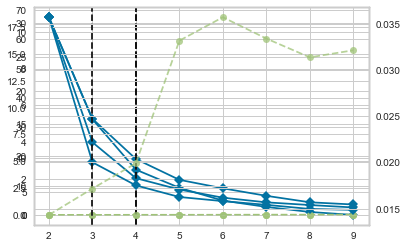

time: 2.43 s


In [4]:
import seaborn as sns
iris = sns.load_dataset('iris')
patterns = find_patterns(iris)
patterns